# Self-Driving Car Engineer Nanodegree

## Project: Advanced Lane Finding

This notebook is my attempt at Project #4. The goal of this project is to write a software pipeline to identify the lane boundaries in a video from a front-facing camera on a car.


---
## Step 0: Import the Useful Packages

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import imageio
import os
imageio.plugins.ffmpeg.download()
%matplotlib inline

---

## Step 1: Calibrate the Camera

I will compute the camera matrix and distorsion coefficients for the front mounted camera.


In [2]:
#From Camera Calibration Lecture Link - direct rip off almost
#Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
checkersInX = 9 #the number of dark/white corners counted left to right
checkersInY = 6 #the number of dark/white cornerrs counted top to bottom

objp = np.zeros((checkersInX*checkersInY,3), np.float32)
objp[:,:2] = np.mgrid[0:checkersInX, 0:checkersInY].T.reshape(-1,2) #sweet new way of filling array

#Arrays to store object points and image points from all the images
objpoints = [] #3D points from what the picture is actually like in real life
imgpoints = [] #2D points from the picture

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg') #grabs all of my images with calibration# name, awesome!

print("Number of calibration images: " + str(len(images))) #how many images
mytruecounter = 0 #how many times teh cv2.findCheckers worked, found not always, but 9 and 6 work the best

#Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname) #read in the images
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #using cv2 to read in, thus BGR to grayscale

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (checkersInX,checkersInY), None)   
    
    # If found, add object points, image points
    if ret == True:
        mytruecounter = mytruecounter + 1
        objpoints.append(objp)
        imgpoints.append(corners)

print("Number of checker finds: " + str(mytruecounter))

Number of calibration images: 20
Number of checker finds: 17


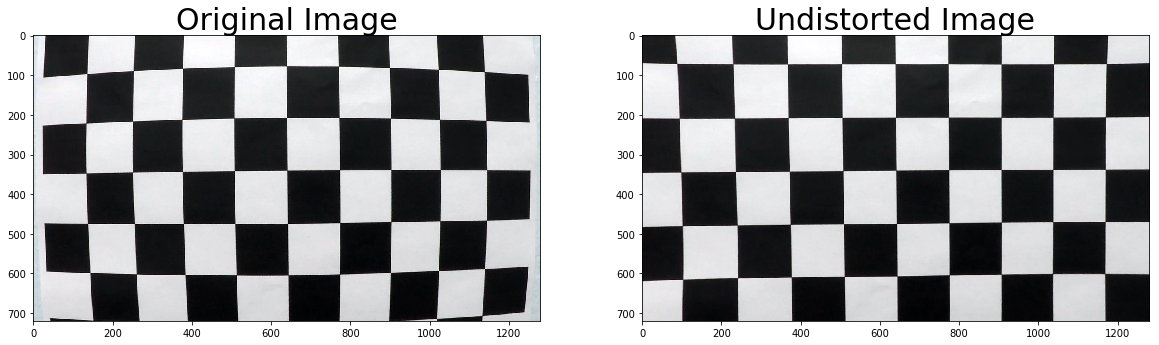

In [3]:
#From Camera Calibration Lecture Link
#Test undistortion on an image, tested on image1 which failed in checker read
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

dst = cv2.undistort(img, mtx, dist, None, mtx) #undistort the images
cv2.imwrite('writeupPics/test_undistCheckers.jpg',dst) #save image to a file undistorted
cv2.imwrite('writeupPics/test_distCheckers.jpg',img) #save image to a file distorted

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

# Step 2: Example of Distortion Corrected Image

This is just to show my camera calibration worked.

In [4]:
#read in an image and display it undistorted
#def undistortMe(img, objpoints, impoints)

def undistortMe(imgage):
    img = cv2.imread(imgage)
    dst1 = cv2.undistort(img, mtx, dist, None, mtx) #undistort the images
    dst1 = cv2.cvtColor(dst1, cv2.COLOR_BGR2RGB) #flip back to rgb
    
    #Visualize undistortion
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #visualize rgb, looks funny without
    #dst1 = cv2.cvtColor(dst1, cv2.COLOR_BGR2RGB)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(dst1)
    ax2.set_title('Undistorted Image', fontsize=30)
    #cv2.imwrite('writeupPics/test_undist1.jpg',dst1) #save image to a file undistorted
    #cv2.imwrite('writeupPics/test_dist1.jpg',img) #save image to a file distorted
    
    return dst1



# Step 3: Thresholding

The goal below is to create a binary image result that contains, at a minimum, of where the lane lines might be.

In [5]:
#From the color and gradient lecture, going to use sobel x and hls, s-channel
def threshold(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    image = np.copy(img)
    
    #convert to HLS color space and separate the S channel
    hsl = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hsl[:,:,2]
    
    #grayscale the image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Stack each channelS
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    #Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=40)

    ax2.imshow(combined_binary, cmap='gray')
    ax2.set_title('Binary Result', fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    #Visualize
    #cv2.imwrite('writeupPics/binary.jpg', combined_binary) #save image to a file distorted
    
    return combined_binary
    

# Step 4: Prespective Transform

The goal below is to create a function to give my image a "birds-eye view".

In [15]:
#From Undistort and Transform Quiz and 'How I Did It'
def warped(img, mtx, dist):
    #get the shape
    img_size = (img.shape[1], img.shape[0])
    #print(img_size)

    # For source points I'm grabbing the outer four detected corners from Paint
    srcs = np.float32([[581,460],[702,460],[1110,img_size[1]],[200,img_size[1]]])
    # For destination points, 
    dest = np.float32([[185,0],[1095,0],[1095,720],[185,720]])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(srcs, dest)
    Minv = cv2.getPerspectiveTransform(dest, srcs)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)

    #get a warped image
    #top_down, Minv= warped(img, mtx, dist)

    #draw some lines on the images
    imageCopy = img.copy()
    pts = np.array([[581,460],[702,460],[1110,720],[200,720]], np.int32)
    pts = pts.reshape((-1,1,2))
    image2 = cv2.polylines(imageCopy,[pts],True,(0,255,26),5)

    top_downCopy = warped.copy()
    ptsTop = np.array([[185,0],[1095,0],[1095,720],[185,720]], np.int32)
    ptsTop = ptsTop.reshape((-1,1,2))
    top_down2 = cv2.polylines(top_downCopy,[ptsTop],True,(0,255,26),5)

    #Visualize
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img, cmap='gray')
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(top_down2)
    ax2.set_title('Warped Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)    

    # Return the resulting image and matrix
    return warped, Minv




# Step 5: Curved Lines

The goal below is to identify lane-line pixels and fit their positions with a polynomial

In [7]:
#From Implement Sliding Windows and Fit a Polynomial
# Read in a thresholded image
def curvedLinesFirst(binary_warped):
    #curvedLinesFirst.has_been_called = True
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
    return ploty, left_fit, right_fit, left_fitx, right_fitx


# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
def curvedLinesNext(binary_warped, left_fit, right_fit):
    left_fitOld = left_fit.copy()
    right_fitOld = right_fit.copy()
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    #Visualize
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

    return ploty, left_fit, right_fit, left_fitx, right_fitx, changeInLeft, changeInRight    


# Step 6: Find Lane Curvature and Center

The goal below is to identify lane-line pixels and fit their positions with a polynomial

In [8]:
#Taken from Lecture and Advanced Lane write-up example

def curvesandCenter(ploty, left_fit, right_fit, left_fitx, right_fitx):
    
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    #print(left_curverad, right_curverad)
    # Example values: 1926.74 1908.48

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    #print(left_fit) straight lines caused so much pain, not writing all of the code

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2) #changed to fitted line
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2) #changed to fitted line
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m


    #center of lane stuff, assume lane should always be in center, drift is caused by lane to shift left or right
    centerOfLanePixels = 640 #1280/2 for the image
    leftLane = left_fitx[-1] #should be the bottom
    rightLane = right_fitx[-1]
    laneWidthPixels = rightLane - leftLane #to stay positive gives lane width
    carCenterPixels = (laneWidthPixels/2) + leftLane #should be center
    carMissedByPixels = centerOfLanePixels - carCenterPixels
    carMissedByMeters = carMissedByPixels * xm_per_pix

    #print(carCenterPixels)
    #print(carMissedByPixels)
    #print(carMissedByMeters)

    rightOrLeft = ""

    if carMissedByMeters > 0: #for display purposes only
        rightOrLeft = "Left"
    else:
        rightOrLeft = "Right"
    
    carMissedByMetersABS = np.absolute(carMissedByMeters) #since we are giving a left or right
    
    return left_curverad, right_curverad, rightOrLeft, carMissedByMetersABS
      


# Step 7: Back to the Real World

The goal below is to undo everything and paint lines on an image

In [9]:
# Create an image to draw the lines on
# From lecture and help guide

def backtoRoad(img, left_fitx, right_fitx, ploty, Minv, left_curverad, right_curverad, rightOrLeft, carMissedByMetersABS):
    img = cv2.imread(img)
    warp_zero = np.zeros_like(img).astype(np.uint8)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(warp_zero, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(warp_zero, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result2 = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    font = cv2.FONT_HERSHEY_COMPLEX
    cv2.putText(result2,"Radius of Left Curvature: %dm" %left_curverad,(10,60), font, 2,(255,255,255),5,cv2.LINE_AA)
    cv2.putText(result2,"Radius of Right Curvature: %dm" %right_curverad,(10,125), font, 2,(255,255,255),5,cv2.LINE_AA)
    cv2.putText(result2,"Car is %0.3fm to the %s" %(carMissedByMetersABS, rightOrLeft),(10,190), font, 2,(255,255,255),5,cv2.LINE_AA)
    
    #plt.imshow(result2)
    
    return result2



# Step 8: Pipeline for Image

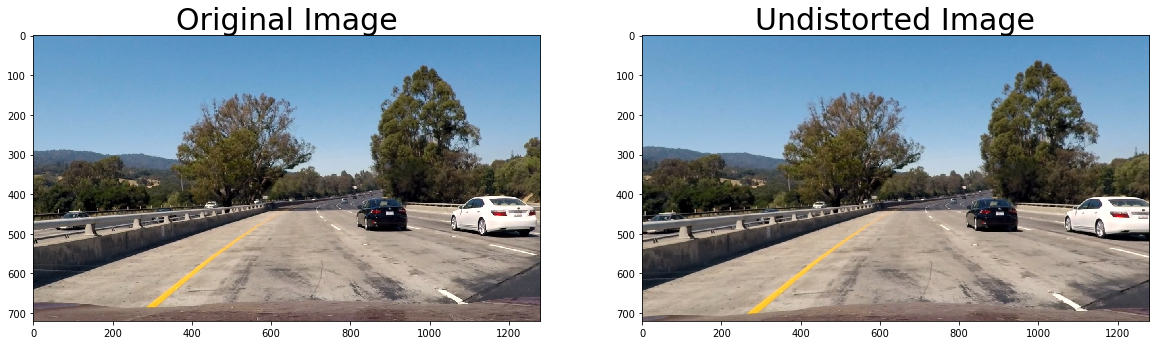

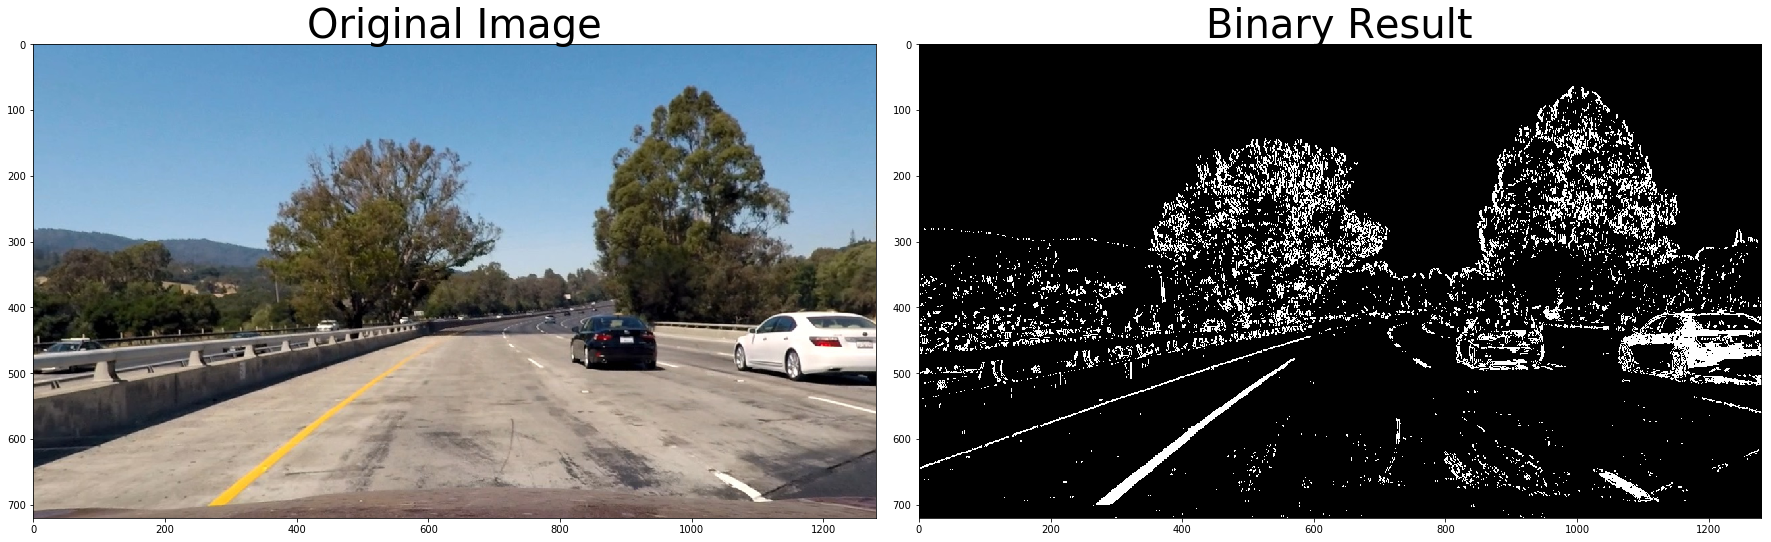

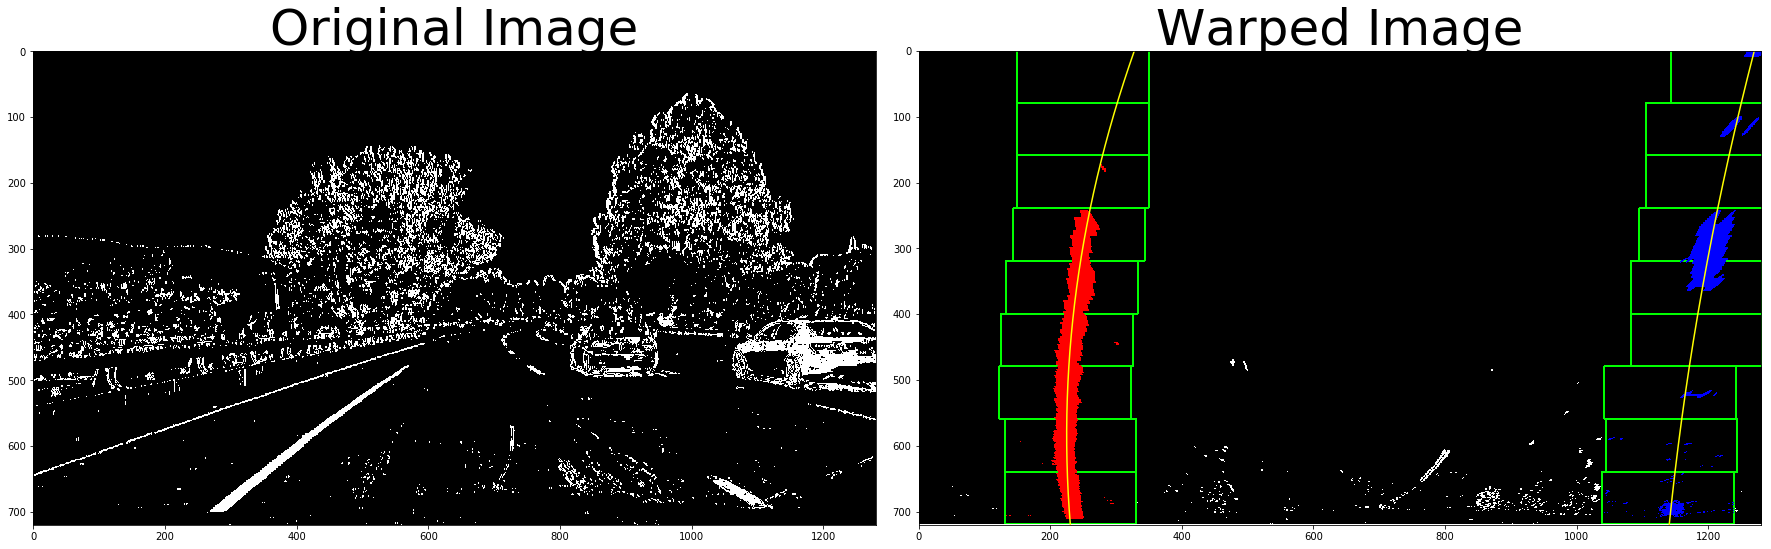

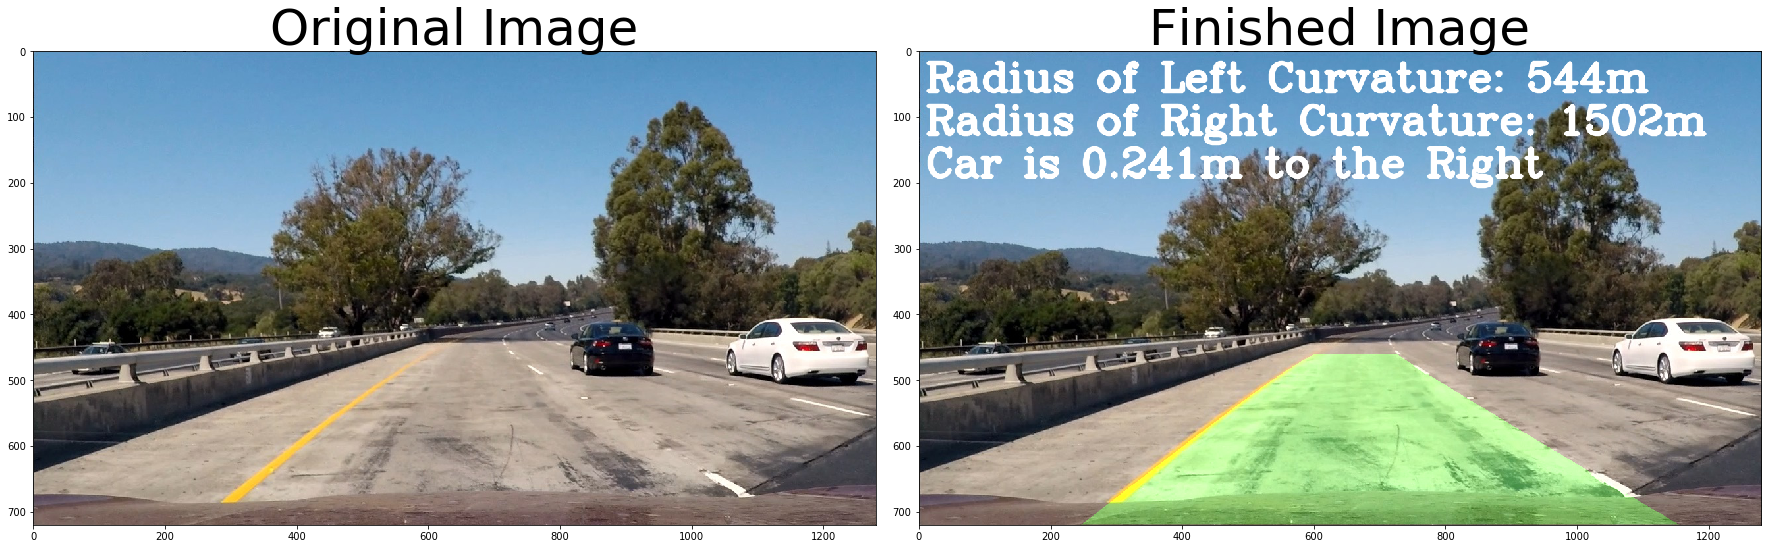

In [16]:
def myPipeline(image):
    
    #make a copy
    originalImage = cv2.imread(image)
    originalImage = image #cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #flip back to rgb
    
    #distortion correction
    undistorted = undistortMe(image) #returns an undistorted rgb image
    
    #binary image
    binary = threshold(undistorted) #returns a binary image, stacked S(HLS) channel and sobel X
    
    #binary_warped
    binary_warped, Minv = warped(binary, mtx, dist)
        
    #perspective birds-eye view/check this
    ploty, left_fit, right_fit, left_fitx, right_fitx = curvedLinesFirst(binary_warped)
    
    #get curvature and center of lane info
    left_curverad, right_curverad, rightOrLeft, carMissedByMetersABS = curvesandCenter(ploty, left_fit, right_fit, left_fitx, right_fitx)
    
    #final output
    finalresult = backtoRoad(originalImage, left_fitx, right_fitx, ploty, Minv, left_curverad, right_curverad, rightOrLeft, carMissedByMetersABS)
        
    return finalresult

original = cv2.imread('test_images/test1.jpg')
hello2 = myPipeline('test_images/test1.jpg')

#Compare the start and finish
original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB) #flip back to rgb
hello2 = cv2.cvtColor(hello2, cv2.COLOR_BGR2RGB) #flip back to rgb
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(original)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(hello2)
ax2.set_title('Finished Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)  
